In [1]:
import numpy as np
import pandas as pd
import torch
import csv, random
import torch.nn.init as init
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence, pack_sequence
from sklearn.metrics import roc_auc_score, accuracy_score
import torch.optim as optim
from torch.autograd import Variable
from sklearn.externals import joblib
import time, math
from datetime import datetime

In [2]:
HIDDEN_SIZE = 50
# EMBEDDING_SIZE = 200
HIDDEN_LAYER_SIZE = 1
DROPOUT_RATE = 0.5
EPOCHS = 30
BATCH_SIZE = 16
USE_CUDA = True

In [3]:
def read_data_from_csv_file(filename):
    tuples = []
    targets = []
    seen_probs = []
    n_seq = None
    with open(filename, "r") as csvfile:
        csvreader = csv.reader(csvfile, delimiter=',')
        while not n_seq:
            n_seq = next(csvreader)
        n_seq = int(n_seq[0])
        pids = next(csvreader)
        targets = next(csvreader)
        while targets:
            try:
                if len(pids) >= 2:
                    seen_probs += [p for p in set(pids) if p not in seen_probs]
                    tuples.append((n_seq,list(zip(map(int,pids),map(int,targets)))))
                n_seq = int(next(csvreader)[0])
                pids = next(csvreader)
                targets = next(csvreader)
            except StopIteration:
                tuples.append((n_seq,list(zip(map(int,pids),map(int,targets)))))
                targets = None
    print("The number of students is ", len(tuples))

    id2idx = { int(j): int(i + 1) for i, j in enumerate(seen_probs)}
    id2idx[999] = 0
    return tuples, id2idx

In [4]:
def read_data(path):
    """
    从文件中读取数据
    :param path: str 文件路径
    :return: int 知识点数量, sequence 原始数据序列
    """
    with open(path, 'r', encoding='UTF-8') as f:
        skill_dt = {}
        seq_dt = {}
        readlines = csv.reader(f)
        for i, readline in enumerate(readlines):
            if i == 0:
                continue
            skill_id = readline[1]
            user_id = readline[0]
            correct = 1 if readline[4] == 'True' else 0
            if skill_id == '' or user_id == '' or correct == '':
                continue
            if skill_id not in skill_dt:
                skill_dt[skill_id] = len(skill_dt)
            if user_id in seq_dt:
                seq_dt[user_id].append((skill_dt[skill_id], correct))
            else:
                seq_dt[user_id] = [(skill_dt[skill_id], correct)]
        seq_list = list(seq_dt.values())
        return skill_dt, seq_list

    
def split_dataset(seqs, val_rate=0.2, test_rate=0.2):
    """
    将数据拆分为训练集，验证集和测试集
    :param seqs: sequence 原始数据序列
    :param val_rate: float 验证集占总体数据比
    :param test_rate: float 测试集占总体数据比
    :return:
    """
    random.shuffle(seqs)
    seq_size = len(seqs)
    val_size = int(seq_size * val_rate)
    test_size = int(seq_size * test_rate)
    val_seqs = seqs[:val_size]
    test_seqs = seqs[val_size:val_size + test_size]
    train_seqs = seqs[val_size + test_size:]
    return train_seqs, val_seqs, test_seqs


# 对源数据进行抽样

In [5]:
# pro = pd.read_csv('./data/junyi_ProblemLog_original.csv')[['user_id', 'exercise', 'problem_number', 'time_done', 'correct',
#        'points_earned']]
# ex = pd.read_csv('./data/junyi_Exercise_table.csv')[['name', 'prerequisites', 'short_display_name','topic', 'area']]


In [6]:
# data = pd.merge(pro, ex, how='left', left_on='exercise', right_on='name')

In [7]:
# data[data['user_id'].isin(np.random.choice(data['user_id'].unique(), 10000))].sort_values(['user_id', 'time_done']).reset_index(drop=True).to_csv('./data/edu_sample.csv',index=False)

In [77]:
data = pd.read_csv('./data/edu_sample.csv')


In [78]:
data

,user_id,exercise,problem_number,time_done,correct,points_earned,name,prerequisites,short_display_name,topic,area
0,22,reading_tables_1,1,1412005609551640,False,0,reading_tables_1,"multiplication_1.5,common_form_for_life",表格1,statistics,probability-statistics
1,55,understanding_comparing_angle,1,1414938559497690,True,75,understanding_comparing_angle,recognizing_rays_lines_and_line_segments,認識角並比較角的大小,basic-geometry,geometry
2,55,understanding_comparing_angle,2,1414938612002740,False,0,understanding_comparing_angle,recognizing_rays_lines_and_line_segments,認識角並比較角的大小,basic-geometry,geometry
3,77,prime_factorization,1,1419654893130770,True,75,prime_factorization,"prime_numbers,composite_numbers",質因數分解法,factors-multiples,arithmetic
4,77,prime_factorization,2,1419654943806440,True,75,prime_factorization,"prime_numbers,composite_numbers",質因數分解法,factors-multiples,arithmetic
5,77,least_common_multiple,1,1419655046437760,True,75,least_common_multiple,"prime_factorization,get_gcd_and_lcm",最小公倍數,factors-multiples,arithmetic
6,77,least_common_multiple,2,1419655084822810,True,75,least_common_multiple,"prime_factorization,get_gcd_and_lcm",最小公倍數,factors-multiples,arithmetic
7,77,least_common_multiple,3,1419655126200680,True,75,least_common_multiple,"prime_factorization,get_gcd_and_lcm",最小公倍數,factors-multiples,arithmetic
8,77,least_common_multiple,4,1419655183479050,True,75,least_common_multiple,"prime_factorization,get_gcd_and_lcm",最小公倍數,factors-multiples,arithmetic
9,77,least_common_multiple,5,1419655203714830,True,75,least_common_multiple,"prime_factorization,get_gcd_and_lcm",最小公倍數,factors-multiples,arithmetic


In [89]:
topic_dict=dict(zip(data.name, data.topic))

In [79]:
name_dict=dict(zip(data.exercise, data.short_display_name))

In [10]:
len(data)

1064319

In [11]:
len(data[data['correct']==False])

184396

In [12]:
len(set(data['user_id'].tolist()))

9799

In [13]:
len(set(data['exercise'].tolist()))

705

In [14]:
len(set(data['topic'].tolist()))

39

In [15]:
skill_dt, seq_list = read_data('./data/edu_sample.csv')
train_seqs, val_seqs, test_seqs = split_dataset(seq_list)

In [16]:
import os

import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

class TextDataset(Dataset):
    def __init__(self, id2idx, datas):
#         self._seq_list = [[(id2idx.get(problem, 0), target) for (problem, target) in data]  for (userid,data) in datas ]
#         self._seq_list.sort(key=lambda tup: len(tup[1]), reverse=True) 

        self._skill_size = len(id2idx)
        self._seq_list = datas

    def __getitem__(self, index):
        feature_size = self._skill_size * 2
        seq = self._seq_list[index]
        seq_size = len(seq)
        x = torch.zeros(seq_size, feature_size)
        y_skill = torch.zeros(seq_size, self._skill_size)
        y_ans = torch.zeros(seq_size)
        for i, v in enumerate(seq):
            if i < seq_size - 1:
                new_feature_v = torch.zeros(feature_size)
                # skill_id * 2 + correct
                idx = int(v[0] * 2 + v[1])
                new_feature_v[idx] = 1
                x[i + 1] = new_feature_v
            new_skill_v = torch.zeros(self._skill_size)
            new_skill_v[v[0]] = 1
            y_skill[i] = new_skill_v
            y_ans[i] = v[1]
        if USE_CUDA:
            x, y_skill, y_ans = Variable((x).cuda()),\
                                Variable((y_skill).cuda()),\
                                Variable((y_ans).cuda())

        else:
            x, y_skill, y_ans =  Variable((x)),\
                               Variable((y_skill)),\
                               Variable((y_ans))
        return x, y_skill, y_ans
    
    def __len__(self):
        return len(self._seq_list)


class TextDataLoader(DataLoader):

    def __init__(self, *args, **kwargs):
        super(TextDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn

    def _collate_fn(self, batch):
        # 压紧序列前需要先排序
        batch.sort(key=lambda x: x[0].size()[0], reverse=True)
        y_skill = []
        y_ans = []
        x = []
        for each_x, each_y, each_ans in batch:
            x.append(each_x)
            y_skill.append(each_y)
            y_ans.append(each_ans)
        # 压紧序列数据
        x_batch = pack_sequence(x)
        # delta(t+1)和a_{t+1}不用保留序列结构信息
        y_skill_batch = pack_sequence(y_skill).data
        y_ans_batch = pack_sequence(y_ans).data
        return x_batch, y_skill_batch, y_ans_batch


In [17]:
train_dataset = TextDataset(skill_dt, train_seqs)
train_dataloader = TextDataLoader(dataset=train_dataset,
                                  batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataset = TextDataset(skill_dt, val_seqs)
test_dataloader = TextDataLoader(dataset=val_dataset, 
                                 batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [90]:
problem = [[name_dict[problem_dict[x]] + "_" + topic_dict[problem_dict[x]] for x,y in data]  for data in train_seqs ]

In [91]:
from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
model = word2vec.Word2Vec(problem, size=100, window=20, min_count=200, workers=4)

d:\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


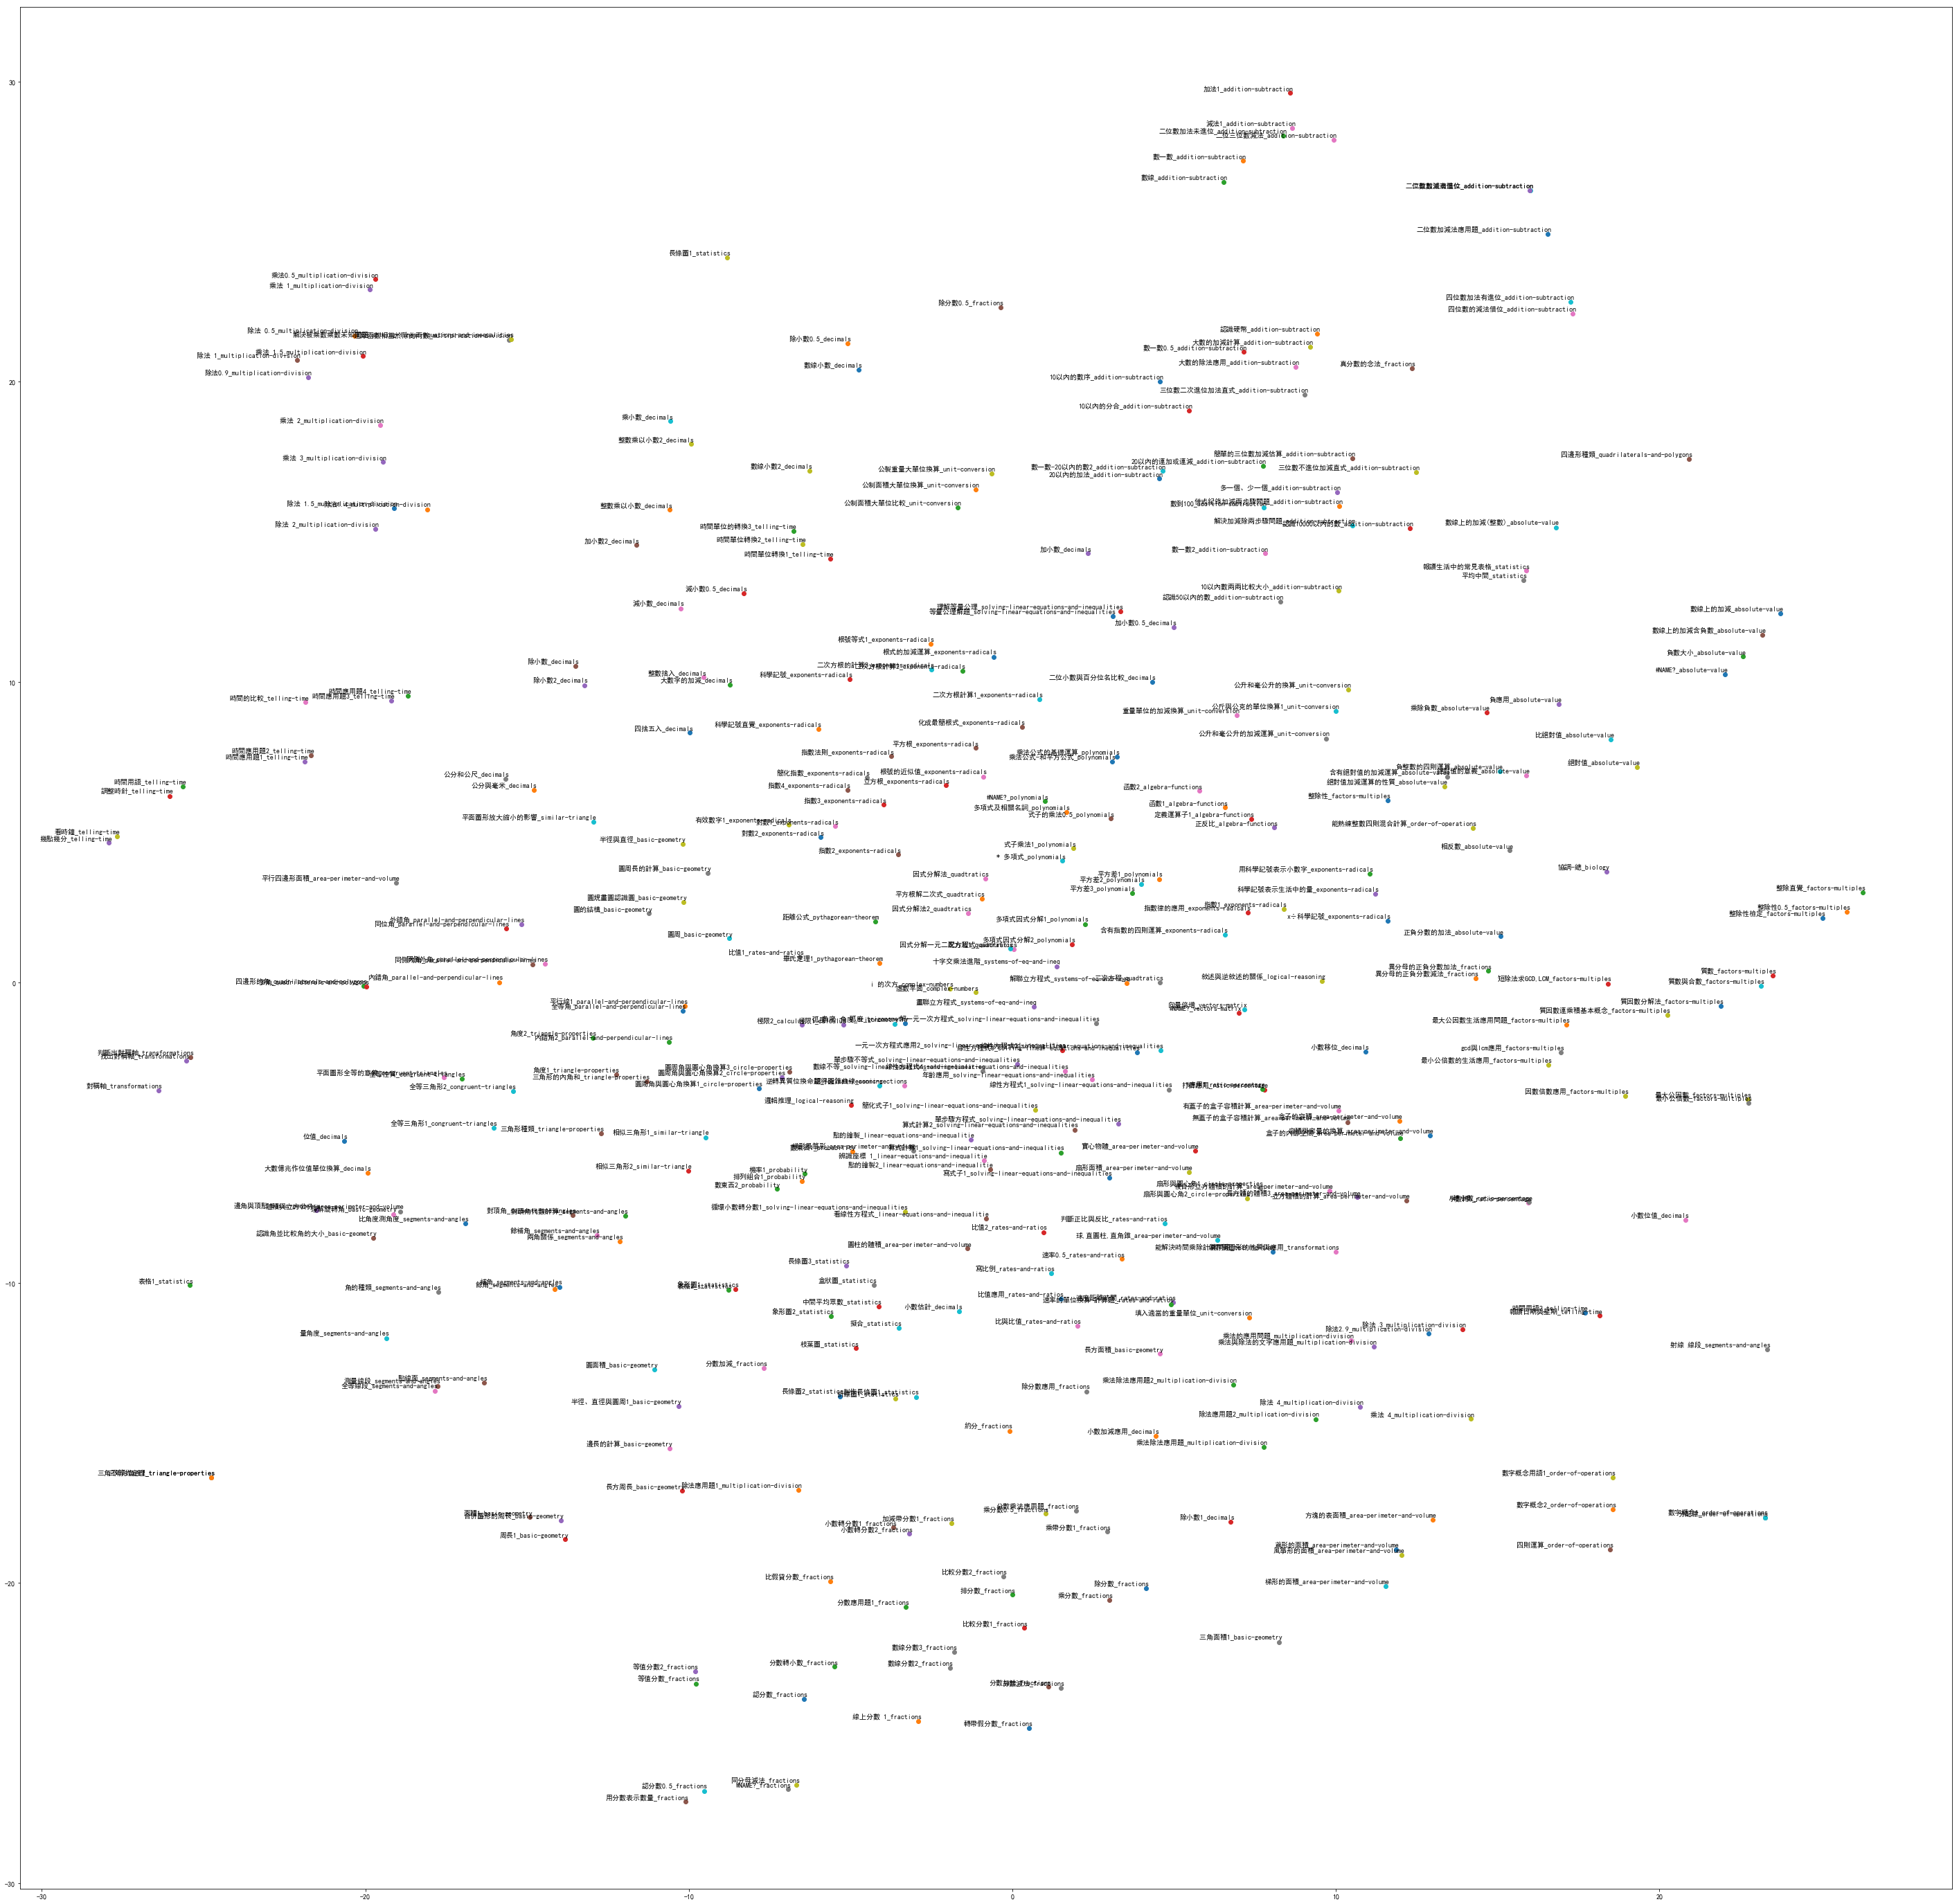

In [94]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(50, 50)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(model)

In [18]:
# train_data,id2idx = read_data_from_csv_file('DeepKnowledgeTracing/data/assistments/train.csv')
# test_data, id2idx2 = read_data_from_csv_file('DeepKnowledgeTracing/data/assistments/test.csv')

In [19]:
# train_dataset = TextDataset(id2idx, train_data)
# train_dataloader = TextDataLoader(dataset=train_dataset,
#                                   batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# test_dataset = TextDataset(id2idx, test_data)
# test_dataloader = TextDataLoader(dataset=test_dataset, 
#                                      batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [20]:
class DktNet(nn.Module):
    def __init__(self, skill_size, rnn_h_size, rnn_layer_size, dropout_rate):
        """
        :param skill_size: int 知识点数量
        :param rnn_h_size: int rnn隐藏单元数量
        :param rnn_layer_size: int rnn隐藏层数量
        :param dropout_rate: float
        """
        super(DktNet, self).__init__()
        self.rnn_layer_size = rnn_layer_size
        self.rnn = nn.LSTM(skill_size * 2, 
                           rnn_h_size,
                           rnn_layer_size,
                          bidirectional=True)
        self.hidden_size = rnn_h_size
        self.dropout = nn.Dropout(p=dropout_rate)
        self.weight_init(self.rnn)
        self.linear = nn.Linear(rnn_h_size * 2, skill_size)
        self.weight_init(self.linear)
        self.sigmoid = nn.Sigmoid()
        self.main = nn.Sequential(
            nn.Linear(self.hidden_size * 2, skill_size),
            nn.ReLU(True),
            nn.Linear(skill_size, 1)
        )
        
    def weight_init(self, m):
        if isinstance(m, nn.LSTM):
            for param in m.parameters():
                if len(param.shape) >= 2:
                    init.orthogonal_(param.data)
                else:
                    init.normal_(param.data)
        elif isinstance(m, nn.Linear):
            init.xavier_normal_(m.weight.data)
            init.normal_(m.bias.data)
    
    def init_hidden(self, batch_size):
        hidden_p = Variable(torch.zeros(self.rnn_layer_size * 2, batch_size, self.hidden_size))
        hidden_h = Variable(torch.zeros(self.rnn_layer_size * 2, batch_size, self.hidden_size))
        if USE_CUDA:
            hidden_p=hidden_p.cuda()
            hidden_h=hidden_h.cuda()
        return (hidden_p, hidden_h)

    def forward(self, problem, hidden):
        rnn_output, hidden = self.rnn(problem, hidden)
#         pad_rnn, lengths = pad_packed_sequence(rnn_output,batch_first=True)
        
        dropout_output = self.dropout(rnn_output.data)
        linear_output = self.linear(dropout_output)
        output = self.sigmoid(linear_output)
#         attn_ene = self.main(rnn_output.data.view(-1, rnn_output.data.size(1))) # (b, s, h) -> (b * s, 1)
#         attns = F.softmax(attn_ene.view(rnn_output.data.size(0), -1), dim=1) # (b * s, 1) -> (b, s, 1)
#         feats = (dropout_output * attns)
# #         feats = pack_padded_sequence(feats, lengths, batch_first=True)
#         output = self.sigmoid(self.linear(feats.data))
        return output, hidden

In [21]:
def compute_auc(data_loader, model):
    """
    计算验证集和测试集的auc值
    """
    y_pred = torch.tensor([])
    y_ans = torch.tensor([])
    for x_batch, y_skill_batch, y_ans_batch in data_loader:
        hidden = model.init_hidden(BATCH_SIZE)
        skill_pred, _ = model(x_batch, hidden)
        _y_pred = (skill_pred.data * y_skill_batch).sum(dim=1)
        y_pred = torch.cat((y_pred, _y_pred.cpu()))
        y_ans = torch.cat((y_ans, y_ans_batch.cpu()))
    return roc_auc_score(y_ans, y_pred)

In [22]:
model = DktNet(len(skill_dt), HIDDEN_SIZE, HIDDEN_LAYER_SIZE, DROPOUT_RATE)
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params=trainable_params, lr=0.001, betas=(
        0.9, 0.999), eps=1e-08, weight_decay=0)
criterion = nn.BCELoss()
criterion = criterion.cuda()
model = model.cuda()

In [23]:
for epoch in range(EPOCHS + 1):
    start_time = time.time()
    train_y_pred = torch.tensor([])
    train_y_ans = torch.tensor([])
    model.train()
    start_time = time.time()
    batch_losses = 0
    batch_metrics = 0
    for batch, datas in enumerate(train_dataloader):
        x_batch, y_skill_batch, y_ans_batch = datas
        optimizer.zero_grad()
        hidden = model.init_hidden(BATCH_SIZE)
        outputs, hidden = model(x_batch, hidden)
        y_pred = (outputs * y_skill_batch).sum(dim=1)
        loss = criterion(y_pred, y_ans_batch)
        train_y_pred = torch.cat((train_y_pred, y_pred.cpu()))
        train_y_ans = torch.cat((train_y_ans, y_ans_batch.cpu()))
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 5)
        optimizer.step()

        batch_losses += loss.data
        if batch % 50 == 0 and batch > 0:
            cur_loss = batch_losses[0] / 200
            elapsed = time.time() - start_time

            print('| epoch {:3d} | {:5d}/{:5d} batches  | lr {:05.5f} | ms/epoch {} | '
                  'loss {:5.5f} '.format(
                epoch, batch, len(train_dataloader), optimizer.param_groups[0]['lr'],
                str(elapsed), cur_loss))
            batch_losses = 0
            start_time = time.time()
    with torch.no_grad():
        # 验证集auc
        val_auc = compute_auc(test_dataloader, model)
        # 训练集auc
        train_auc = roc_auc_score(train_y_ans, train_y_pred.detach().numpy())
        print('epoch: {0}, train_auc: {1}, val_auc: {2}'.format(epoch + 1, train_auc, val_auc))
    if epoch % 10 == 0 and epoch > 1 :
        print('reduce learning rate by multiply 0.7')
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.7


d:\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:19: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
d:\anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


| epoch   0 |    50/  367 batches  | lr 0.00100 | ms/epoch 6.167510509490967 | loss 0.17385 
| epoch   0 |   100/  367 batches  | lr 0.00100 | ms/epoch 5.674826622009277 | loss 0.11190 
| epoch   0 |   150/  367 batches  | lr 0.00100 | ms/epoch 4.096049070358276 | loss 0.11050 
| epoch   0 |   200/  367 batches  | lr 0.00100 | ms/epoch 4.682480096817017 | loss 0.11160 
| epoch   0 |   250/  367 batches  | lr 0.00100 | ms/epoch 5.782538652420044 | loss 0.11131 
| epoch   0 |   300/  367 batches  | lr 0.00100 | ms/epoch 4.974700689315796 | loss 0.10743 
| epoch   0 |   350/  367 batches  | lr 0.00100 | ms/epoch 3.7778995037078857 | loss 0.10221 
epoch: 1, train_auc: 0.6526062802505657, val_auc: 0.7254494443157897
| epoch   1 |    50/  367 batches  | lr 0.00100 | ms/epoch 5.479348421096802 | loss 0.10454 
| epoch   1 |   100/  367 batches  | lr 0.00100 | ms/epoch 4.86103367805481 | loss 0.10132 
| epoch   1 |   150/  367 batches  | lr 0.00100 | ms/epoch 3.9294660091400146 | loss 0.09412 


| epoch  11 |   150/  367 batches  | lr 0.00070 | ms/epoch 4.512934684753418 | loss 0.00411 
| epoch  11 |   200/  367 batches  | lr 0.00070 | ms/epoch 4.739328145980835 | loss 0.00368 
| epoch  11 |   250/  367 batches  | lr 0.00070 | ms/epoch 5.9121928215026855 | loss 0.00344 
| epoch  11 |   300/  367 batches  | lr 0.00070 | ms/epoch 5.118315696716309 | loss 0.00354 
| epoch  11 |   350/  367 batches  | lr 0.00070 | ms/epoch 3.985344648361206 | loss 0.00462 
epoch: 12, train_auc: 0.999953774267224, val_auc: 0.9997547621019524
| epoch  12 |    50/  367 batches  | lr 0.00070 | ms/epoch 4.718384265899658 | loss 0.00336 
| epoch  12 |   100/  367 batches  | lr 0.00070 | ms/epoch 5.21106743812561 | loss 0.00365 
| epoch  12 |   150/  367 batches  | lr 0.00070 | ms/epoch 4.942784547805786 | loss 0.00280 
| epoch  12 |   200/  367 batches  | lr 0.00070 | ms/epoch 4.972705125808716 | loss 0.00366 
| epoch  12 |   250/  367 batches  | lr 0.00070 | ms/epoch 5.542369842529297 | loss 0.00324 
|

| epoch  22 |   250/  367 batches  | lr 0.00049 | ms/epoch 5.316784620285034 | loss 0.00222 
| epoch  22 |   300/  367 batches  | lr 0.00049 | ms/epoch 5.539189577102661 | loss 0.00238 
| epoch  22 |   350/  367 batches  | lr 0.00049 | ms/epoch 4.644582271575928 | loss 0.00267 
epoch: 23, train_auc: 0.9999840068822926, val_auc: 0.9998389963817561
| epoch  23 |    50/  367 batches  | lr 0.00049 | ms/epoch 4.961733341217041 | loss 0.00175 
| epoch  23 |   100/  367 batches  | lr 0.00049 | ms/epoch 5.704747200012207 | loss 0.00211 
| epoch  23 |   150/  367 batches  | lr 0.00049 | ms/epoch 5.6219682693481445 | loss 0.00216 
| epoch  23 |   200/  367 batches  | lr 0.00049 | ms/epoch 4.633611679077148 | loss 0.00202 
| epoch  23 |   250/  367 batches  | lr 0.00049 | ms/epoch 5.354683876037598 | loss 0.00234 
| epoch  23 |   300/  367 batches  | lr 0.00049 | ms/epoch 5.0205769538879395 | loss 0.00180 
| epoch  23 |   350/  367 batches  | lr 0.00049 | ms/epoch 4.7114033699035645 | loss 0.0019

In [24]:
torch.save(model, './chk/dkt.model')

d:\anaconda3\envs\deeplearning\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type DktNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [25]:
def vis_generate(decoder, input_str, temperature=0.8):
    hidden = decoder.init_hidden(1)
    test_len = len(input_str)
    prime_input = torch.autograd.Variable(input_str[0].unsqueeze(0)).cuda()
    print('prime_input', prime_input.shape)
    for p in range(len(prime_input) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
    hidden_matrix = np.copy(hidden[0][0].unsqueeze(0).data.cpu().numpy())
    hidden_matrix = hidden_matrix.reshape((1,hidden_matrix.size))
    inp = prime_input
    for p in range(1,test_len + 1):
        print('p', p)
#         inp = torch.autograd.Variable(input_str[p].unsqueeze(0)).cuda()
        output, hidden = decoder(inp.unsqueeze(0), hidden)
        print('hidden[0][0,0,:]', hidden[0][0,0,:].shape)
        hidden_matrix = np.vstack((hidden_matrix, hidden[0][0,0,:].data.cpu().numpy()))
        if p < (test_len):
            inp = torch.autograd.Variable(input_str[p].unsqueeze(0)).cuda()
    hidden_matrix = np.delete(hidden_matrix, 0, 0)
    df = pd.DataFrame(hidden_matrix)
    df.to_csv('paran-data-df.csv')
    np.savetxt("paren-data.csv", hidden_matrix, delimiter=",")
    np.savetxt("paren-data.tsv", hidden_matrix, delimiter="\t")

In [26]:
problem_dict = {v:k for k,v in skill_dt.items()}


In [27]:
test = [(29, 1), (30, 1), (31, 1), (30, 1), (31, 1), (29, 1), (29, 1), (31, 1)]

In [28]:
[problem_dict[x[0]] for x in test]

['representing_numbers',
 'number_line',
 'addition_1',
 'number_line',
 'addition_1',
 'representing_numbers',
 'representing_numbers',
 'addition_1']

In [29]:
inputs = test # test_seqs[22]
feature_size = len(skill_dt) * 2
seq_size = len(inputs)
x = torch.zeros(seq_size, feature_size)
for i, v in enumerate(inputs):
    if i < seq_size - 1:
        new_feature_v = torch.zeros(feature_size)
        # skill_id * 2 + correct
        idx = int(v[0] * 2 + v[1])
        new_feature_v[idx] = 1
        x[i + 1] = new_feature_v

vis_generate(model, x)

prime_input torch.Size([1, 1410])
p 1
hidden[0][0,0,:] torch.Size([50])
p 2
hidden[0][0,0,:] torch.Size([50])
p 3
hidden[0][0,0,:] torch.Size([50])
p 4
hidden[0][0,0,:] torch.Size([50])
p 5
hidden[0][0,0,:] torch.Size([50])
p 6
hidden[0][0,0,:] torch.Size([50])
p 7
hidden[0][0,0,:] torch.Size([50])
p 8
hidden[0][0,0,:] torch.Size([50])


In [30]:
from math import pi
import pandas as pd

from bokeh.io import show
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, BasicTicker, PrintfTickFormatter,ColorBar
from bokeh.models import FuncTickFormatter
from bokeh.plotting import figure

data = pd.read_csv('paran-data-df.csv', index_col=0)
data.index.name = 'chars'
data.columns.name = 'cell'


In [33]:
data2 = data.diff().fillna(0.0)

In [34]:
%matplotlib inline


In [40]:
from bokeh.io import output_notebook
from bokeh.models import LogColorMapper, LogTicker, ColorBar
output_notebook()

Loading BokehJS ...

In [47]:
index = {i:problem_dict[inputs[i][0]] for i in range(len(data2.index))}

seq = [str(i) for i in data2.index]
cell = list(data2.columns)

df = pd.DataFrame(data2.stack(), columns=['value']).reset_index()
colors = ["#313695", "#4575b4", "#74add1", "#abd9e9", "#e0f3f8", "#ffffbf", "#fee090", "#fdae61", "#f46d43", "#d73027", "#a50026"]

colors.reverse()
mapper = LinearColorMapper(palette=colors, low=-2, high=2)#low=df.value.min(), high=df.value.max())
source = ColumnDataSource(df)
TOOLS = "hover,pan,reset,save,wheel_zoom"

color_bar = ColorBar(color_mapper=mapper, ticker=BasicTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p = figure(title="LSTM Hidden State Activations",  x_range=seq, y_range=list(reversed(cell)), x_axis_location="above",
            plot_width=500, plot_height=700,
            tools=TOOLS, toolbar_location='below')

p.grid.grid_line_color = None
p.axis.axis_line_color = None
p.axis.major_tick_line_color = None
p.axis.major_label_text_font_size = "8pt"
p.axis.major_label_standoff = 0
p.xaxis.major_label_orientation = pi / 3
p.xaxis.formatter = FuncTickFormatter(code="""
                                        var labels = %s;
                                        return labels[tick];
                                    """%index)

p.rect(x="chars", y="cell", width=1, height=1, source=source, fill_color={'field': 'value', 'transform': mapper},
                                line_color=None)

p.select_one(HoverTool).tooltips = [('value', '@value')]
p.add_layout(color_bar, 'right')
show(p)      # show the plot